<a href="https://colab.research.google.com/github/umar052001/Deep-Learning-with-Tensorflow/blob/master/06_Transfer_Learning_with_Tensorflow_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning: Scaling Up (Food Vision Mini)

As we were working with only 10 classes now it's time to scale up things and use all of the classes of food101 dataset from kaggle.

Our goal is to beat the original food101 paper with 10% of data(leaverging the power of deep learning)

Our baseline to beat is 50.76% accuracy across all 101 classes.

https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [1]:
!nvidia-smi

Fri Sep  9 23:52:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [2]:
!wget https://raw.githubusercontent.com/umar052001/Deep-Learning-with-Tensorflow/master/helperFunctions.py

--2022-09-09 23:52:57--  https://raw.githubusercontent.com/umar052001/Deep-Learning-with-Tensorflow/master/helperFunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10512 (10K) [text/plain]
Saving to: ‘helperFunctions.py’

helperFunctions.py  100%[===================>]  10.27K  --.-KB/s    in 0s      

2022-09-09 23:52:57 (99.3 MB/s) - ‘helperFunctions.py’ saved [10512/10512]



In [3]:
from helperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys,walk_through_dir, unzip_data

## 101 Food classes: working with less data (10%)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2022-09-09 23:53:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  58.5MB/s    in 29s     

2022-09-09 23:53:31 (52.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/miso_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 director

In [6]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               shuffle=False) # setting false for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training a big dog modelwith transfer learning on 10% of 101food classes

Here are the steps we're going to take:
* Create a model checkpoint
* Create a data augmentation layer
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extractor for 5 full passes (5 epochs on train dataset and validate on 15% of test data to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it write into our model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
],name="data_augmentation")

In [9]:
# Setup the base model and freeze it's layer
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architechture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs, training=True)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [12]:
# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
          epochs=5,
          validation_data=test_data,
          validation_steps=(0.15 * len(test_data)),
          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 110s 392ms/step - loss: 3.4597 - accuracy: 0.2478 - val_loss: 2.8300 - val_accuracy: 0.3676
Epoch 2/5
237/237 [==============================] - 72s 301ms/step - loss: 2.3419 - accuracy: 0.4589 - val_loss: 2.4692 - val_accuracy: 0.4057
Epoch 3/5
237/237 [==============================] - 62s 260ms/step - loss: 1.9811 - accuracy: 0.5306 - val_loss: 2.3036 - val_accuracy: 0.4378
Epoch 4/5
237/237 [==============================] - 56s 235ms/step - loss: 1.7495 - accuracy: 0.5782 - val_loss: 2.2194 - val_accuracy: 0.4446
Epoch 5/5
237/237 [==============================] - 51s 215ms/step - loss: 1.6097 - accuracy: 0.6073 - val_loss: 2.1436 - val_accuracy: 0.4632


In [13]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 106s 134ms/step - loss: 1.9260 - accuracy: 0.5099


[1.9260053634643555, 0.5099405646324158]

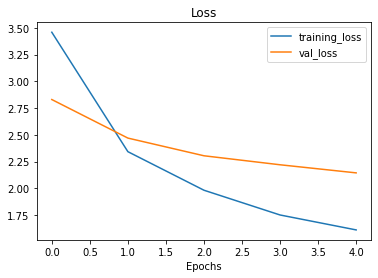

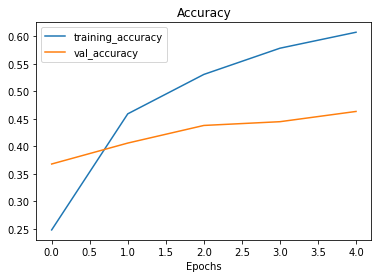

In [14]:
plot_loss_curves(history_all_classes_10_percent)

> Curves suggest that it might be possible that our model is going to overfit.

## Fine tuning

In [15]:
# Unfreeze all of the layers in base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile model with lower learning rate(best practice)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [17]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [18]:
# Fine tune our model
history_fine_tuned_all_classes_10_percent = model.fit(train_data_all_10_percent,
          epochs=10,
          validation_data=test_data,
          validation_steps=(0.15 * len(test_data)),
          initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 53s 194ms/step - loss: 1.3686 - accuracy: 0.6462 - val_loss: 2.0917 - val_accuracy: 0.4703
Epoch 6/10
237/237 [==============================] - 43s 178ms/step - loss: 1.2297 - accuracy: 0.6766 - val_loss: 2.0645 - val_accuracy: 0.4764
Epoch 7/10
237/237 [==============================] - 39s 163ms/step - loss: 1.1601 - accuracy: 0.6920 - val_loss: 2.0602 - val_accuracy: 0.4751
Epoch 8/10
237/237 [==============================] - 40s 166ms/step - loss: 1.0894 - accuracy: 0.7100 - val_loss: 2.0505 - val_accuracy: 0.4811
Epoch 9/10
237/237 [==============================] - 37s 155ms/step - loss: 1.0143 - accuracy: 0.7253 - val_loss: 2.0137 - val_accuracy: 0.4919
Epoch 10/10
237/237 [==============================] - 38s 157ms/step - loss: 0.9878 - accuracy: 0.7413 - val_loss: 2.0378 - val_accuracy: 0.4737


In [19]:
all_classes_fine_tuned_results = model.evaluate(test_data)
all_classes_fine_tuned_results

790/790 [==============================] - 80s 101ms/step - loss: 1.7981 - accuracy: 0.5407


[1.798072099685669, 0.5407128930091858]

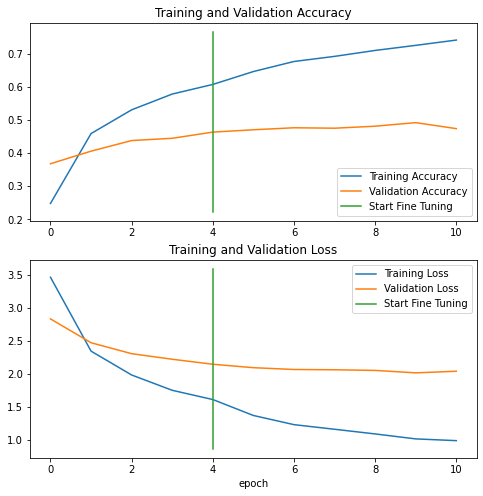

In [20]:
compare_historys(history_all_classes_10_percent,history_fine_tuned_all_classes_10_percent)

## Saving and loading our model

In [21]:
model.save("101_food_classes_10_percent_saved_big_dog_model")

In [22]:
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent_saved_big_dog_model")

In [23]:
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 78s 97ms/step - loss: 1.7975 - accuracy: 0.5406


In [24]:
all_classes_fine_tuned_results

[1.798072099685669, 0.5407128930091858]

## Evaluating the performance of big dog model across all different classes
Let's make some predictions, visualize them and then later find out which predictions were the most wrong

In [25]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-09-10 00:11:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 74.125.200.128, 74.125.130.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  18.6MB/s    in 2.4s    

2022-09-10 00:11:39 (18.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [26]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [27]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [28]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 63s 77ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions on or model

In [29]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 63s 78ms/step


In [30]:
len(pred_probs)

25250

In [31]:
pred_probs.shape

(25250, 101)

In [32]:
pred_probs[:10]

array([[5.9541997e-02, 3.5742044e-06, 4.1377008e-02, ..., 1.4138679e-09,
        8.3530824e-05, 3.0897509e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780820e-04, ..., 5.4287048e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533648e-05, 1.4866963e-03, ..., 7.1891270e-07,
        5.4397265e-07, 4.0275925e-05],
       ...,
       [4.7313246e-01, 1.2931228e-07, 1.4805609e-03, ..., 5.9750048e-04,
        6.6969005e-05, 2.3469245e-05],
       [4.4571832e-02, 4.7265476e-07, 1.2258517e-01, ..., 6.3498501e-06,
        7.5318512e-06, 3.6778776e-03],
       [7.2438955e-01, 1.9249771e-09, 5.2310937e-05, ..., 1.2291373e-03,
        1.5792714e-09, 9.6395648e-05]], dtype=float32)

In [33]:
pred_probs[0]

array([5.9541997e-02, 3.5742044e-06, 4.1377008e-02, 1.0660534e-09,
       8.1614111e-09, 8.6639478e-09, 8.0927191e-07, 8.5652403e-07,
       1.9859070e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
       2.8532185e-04, 7.8049184e-10, 7.4230076e-04, 3.8916409e-05,
       6.4740357e-06, 2.4977301e-06, 3.7891128e-05, 2.0678326e-07,
       1.5538435e-05, 8.1507017e-07, 2.6230514e-06, 2.0010684e-07,
       8.3827518e-07, 5.4216030e-06, 3.7390816e-06, 1.3150530e-08,
       2.7761480e-03, 2.8051860e-05, 6.8562017e-10, 2.5574853e-05,
       1.6688880e-04, 7.6406842e-10, 4.0452872e-04, 1.3150632e-08,
       1.7957391e-06, 1.4448174e-06, 2.3062943e-02, 8.2466846e-07,
       8.5365838e-07, 1.7138658e-06, 7.0525025e-06, 1.8402130e-08,
       2.8553373e-07, 7.9483443e-06, 2.0681568e-06, 1.8525114e-07,
       3.3619767e-08, 3.1522580e-04, 1.0410922e-05, 8.5448272e-07,
       8.4741855e-01, 1.0555444e-05, 4.4094620e-07, 3.7404177e-05,
       3.5306122e-05, 3.2489035e-05, 6.7314730e-05, 1.2852565e

Our model outputs a prediction probability array with N number of variables where N is number of classes.

In [34]:
print(f"Number of prediction probabilities for first sample: {len(pred_probs[0])}")
print(f"Class with highest predicted probability by the model for first sample: {pred_probs[0].argmax()}")

Number of prediction probabilities for first sample: 101
Class with highest predicted probability by the model for first sample: 52


In [35]:
test_data.class_names[52]

'gyoza'

In [36]:
# Get the pred classes for each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [37]:
len(pred_classes)

25250

To evaluate them we need to compare them with original test dataset labels

In [38]:
# To get our test labels we need to unravel our test_data Batchdataset
y_labels= []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0,0,0,1,....0,0,0] we want the index value for max where it's 1

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

One way to check that model's prediction array is in the same order as our test labels array is to find the accuracy score

In [39]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [40]:
# Lets try sklearn accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,
                                  pred_classes)
sklearn_accuracy

0.6077623762376237

In [41]:
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's Visualize: Create a confusion matrix

In [42]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [43]:
# We need to make some changes in our confusion matrix to ensure that our x_labels print vertically
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  

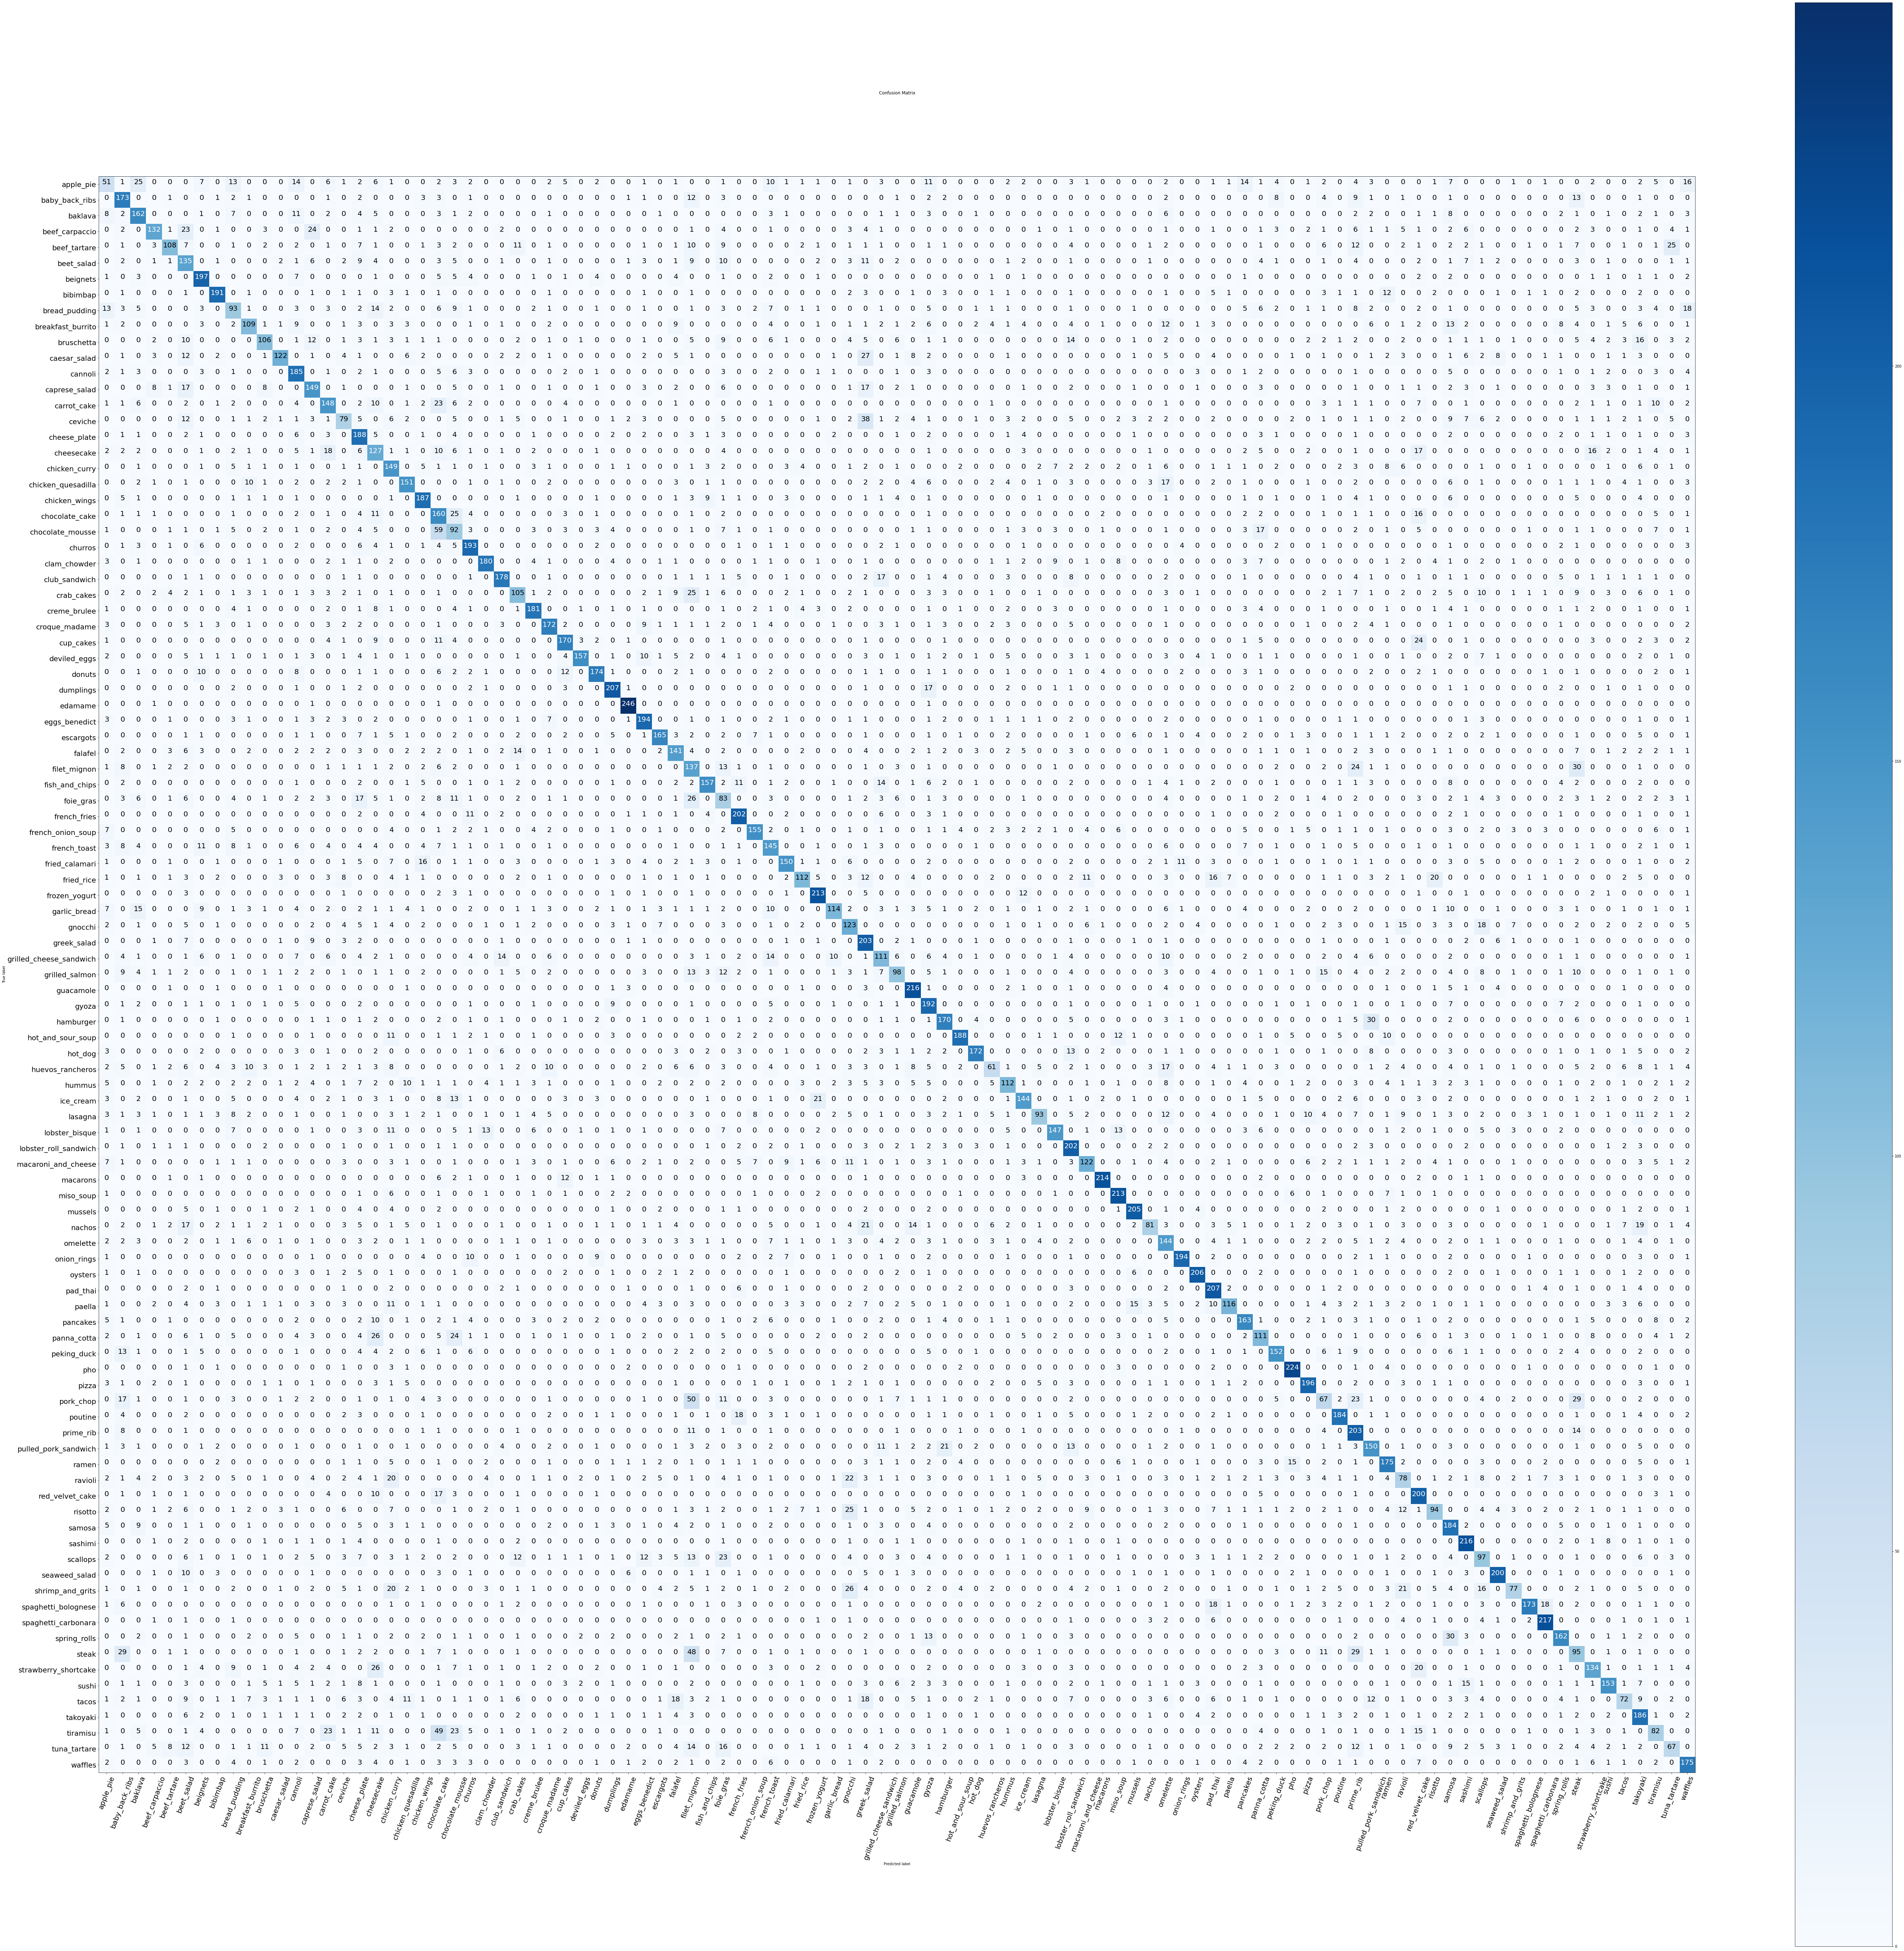

In [44]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

## Its time for a classification report

Sklearn has helpful functions for acquiring many different classification metrics per class eg precision, f1 and recall called classification_report. Let's give it a shot.

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above a great class by class evaluation of our model's predictions but with so many classes.

Let's create a plot. A visulization to get better understanding.

In [46]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [47]:
# Create an empty dictionary
class_f1_score = {}

for key, value in classification_report_dict.items():
  if key == "accuracy":
    break
  else:
    class_f1_score[class_names[int(key)]] = value["f1-score"]

class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [48]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_score.keys()),
                          "f1-score":list(class_f1_score.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

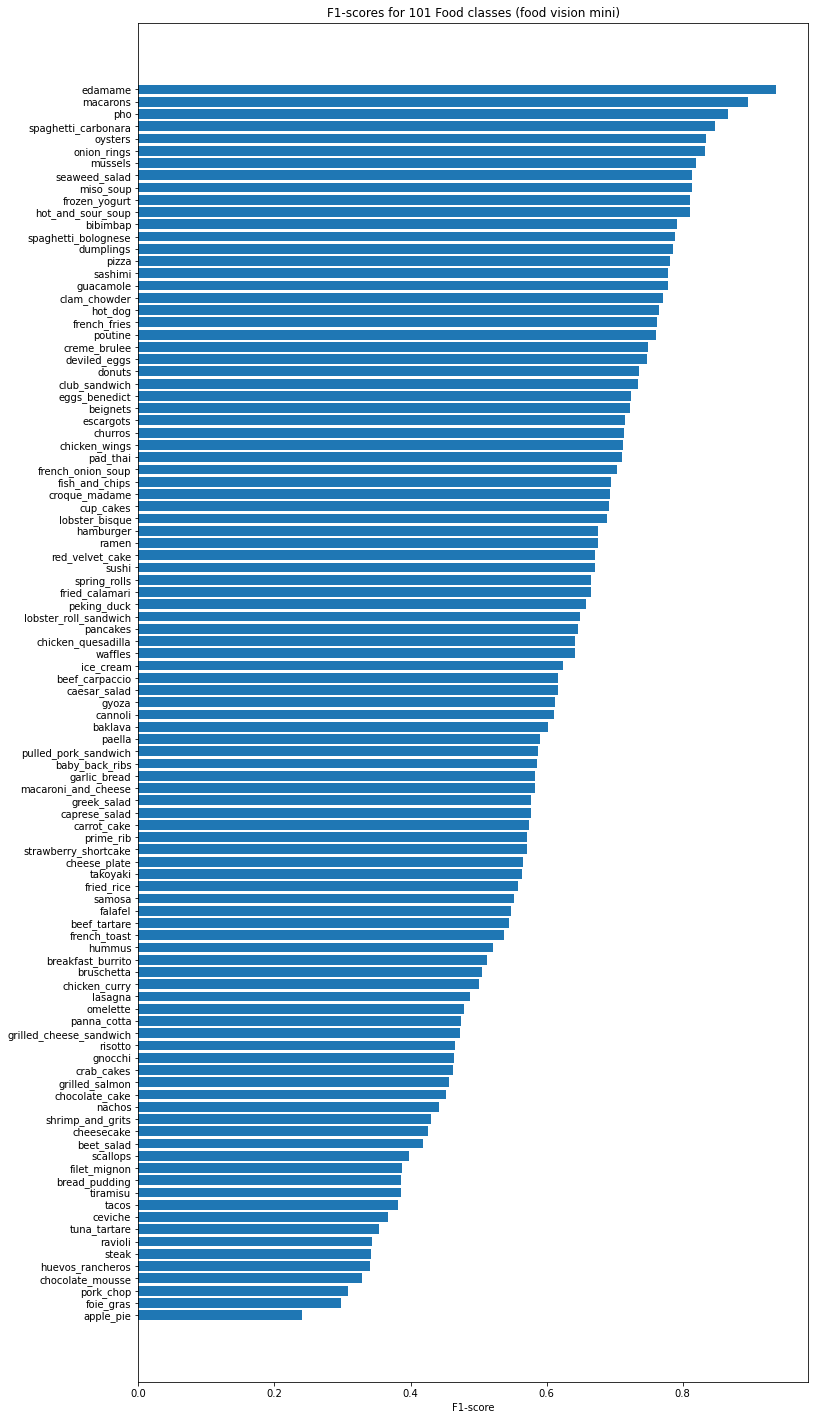

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Food classes (food vision mini)")
ax.invert_yaxis();

## Visualizing Predictions on test images

To visualize, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image file path using tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all the pixel values between 0&1 if necessary

In [50]:
def load_and_prep_image(filename, image_shape=224, scale=True):
  """
  Reads in an image from a filename and turns it into a tensor and reshapes it into specified shape
  (image_shape, image_shape, color_channels=3).
  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  Returns:
    Image tensor of shape (image_shape, image_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize it
  img = tf.image.resize(img,[image_shape, image_shape])

  # Rescale
  if scale:
    return img/255.
  else:
    return img

Let's visualize images, their target labels and our model's predictions.

Specifically:
1. Load few images from test dataset
2. Make predictions on the loaded images 
3. Plot the original images along with the model's predictions, prediction probability and truth label

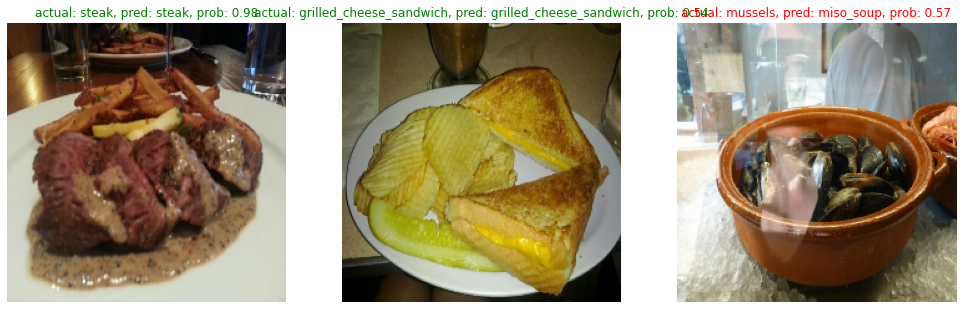

In [52]:
import os
import random

plt.figure(figsize=(17,10))

for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.) # matplotlib needs our images normalized
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions
To find out where our model is most wrong, let's write some code to find out the following:
1. Get all the image filepaths in the test datset using list_files()
2. Create pandas dataframe of image, filepaths and ground truth labels, predicted classes (from our model), max prediction probabilities, pred class names and ground truth class names.
3. Use our DataFrame to find all the wrong predictions 
4. Sort the DataFrame based on wrong predictions having the highest pred prob.
5. Visualize the images with highest prediction probabilities but have the wrong prediction.

In [53]:
# Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())

In [55]:
# Create data frame
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":pred_probs.max(axis=1),
                        "y_true_classnames":[class_names[i] for i in y_labels],
                        "y_pred_classnames":[class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classnames     y_pred_classnames  
0       0.847419         apple_pie                 gyoza  
1       0.964017         apple_pie             apple_pie  
2       0.959259         apple_pie             apple_pie  
3       0.658607         apple_pie  pulled_pork_sandwich  
4       0.367901         apple_pie             prime_rib  
...          ...               ...                   ...  
25245   0.972823           waffles               waffles  
25246   0.878028           waffles          cheese_plate  
25247   0.537899           waffles               waffles  
25248   0.501950           waffles  strawberry_shortcake  
25249   0.690628           waffles               waffles  

[25250 rows x 6 columns]

In [56]:
# Find out which preds are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classnames     y_pred_classnames  pred_correct  
0   0.847419         apple_pie                 gyoza         False  
1   0.964017         apple_pie             apple_pie          True  
2   0.959259         apple_pie             apple_pie          True  
3   0.658607         apple_pie  pulled_pork_sandwich         False  
4   0.367901         apple_pie             prime_rib         False

In [57]:
# Sort our data frame to have most wrong predictions at the top
top_wrong_100 = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_wrong_100

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
...                                                  ...     ...     ...   
8763   b'/content/101_food_classes_10_percent/test/es...      35      41   
2663   b'/content/101_food_classes_10_percent/test/br...      10      61   
7924   b'/content/101_food_classes_10_percent/test/do...      31      29   
18586  b'/content/101_food_classes_10_percent/test/pe...      74      39   
3519   b'/content/101_food_classes_10_percent/test/ca...      14      21   

       pred_conf      y_true_classnames      y_pred_classnames  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997169              escargots      french_onion_soup         False  
2663    0.997055             bruschetta  lobster_roll_sandwich         False  
7924    0.997020                 donuts              cup_cakes         False  
18586   0.996885            peking_duck              foie_gras         False  
3519    0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

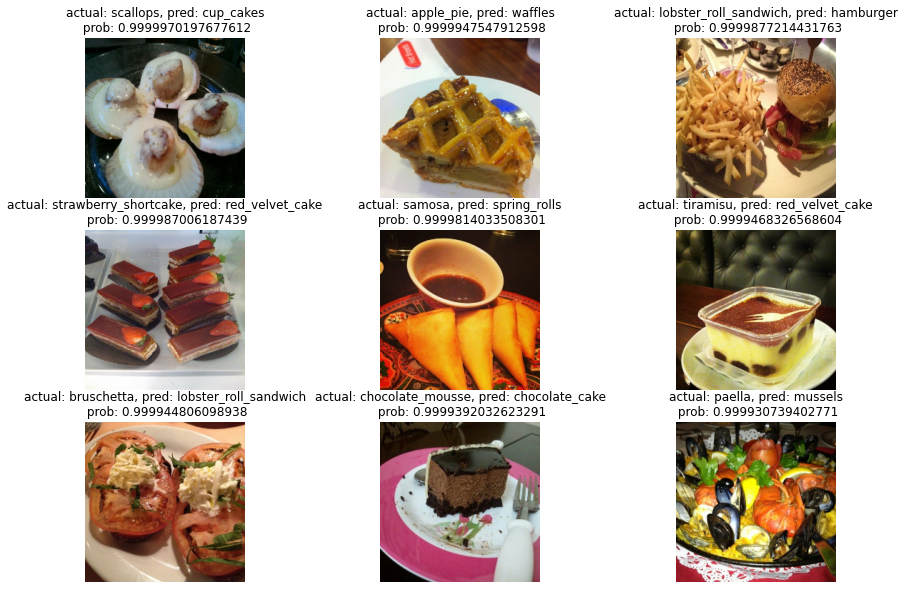

In [63]:
# Visualize the data
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10)) 
for i, row in enumerate(top_wrong_100[start_index : start_index + images_to_view].itertuples()):
  plt.subplot(3,3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in few params
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}\n prob: {pred_prob}")
  plt.axis(False);

## Test out our big dog model on our own custom images

In [64]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2022-09-10 01:02:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  24.7MB/s    in 0.5s    

2022-09-10 01:02:50 (24.7 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [65]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

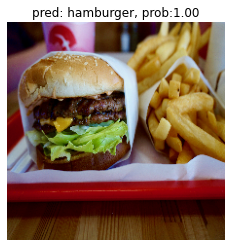

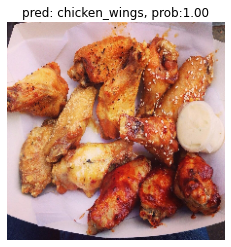

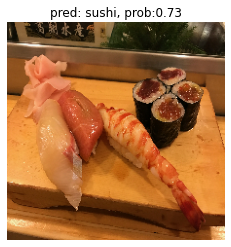

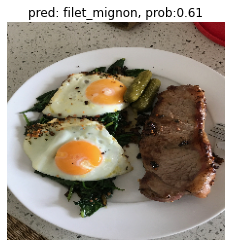

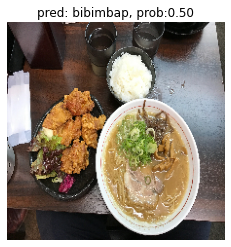

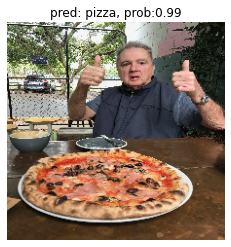

In [66]:
# Make predictions on and plot custom food images 
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  # Plotting
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob:{pred_prob.max():.2f}")
  plt.axis(False)